In [198]:
import torchaudio

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from helpers import extract_metadata 

In [199]:
##### CONFIG #####
SAVE_DF = True
DEBUG = False

MAX_CHARACTERS = 331
MAX_SPEECH = 1114
WAV_FILES = 13100

PERCENTILE = 5 # To pad spectrograms with background noise (currently static)

FOLDER = Path('data/LJSpeech-1.1/wavs')

# NOTE: we are quite complex here using every original character
# Text encoding NOTE: Do not remove the space in CHARSET: """ ABC""""
CHARSET = """ !"$&'(),-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz|£àâèéêü’“”"""

In [200]:
print(CHARSET)
print(f'Size|Len of charset: {len(CHARSET)} characters')

 !"$&'(),-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz|£àâèéêü’“”
Size|Len of charset: 89 characters


In [201]:
df_metadata = extract_metadata()

text_encodings = []
for idx, text in enumerate(df_metadata['text']):
    text_encoded = []
    for char in text:
        text_encoded.append(CHARSET.index(char))

    text_encoded = np.array(text_encoded)
    text_encoded_and_padded = np.pad(text_encoded,(0, MAX_CHARACTERS-len(text_encoded)))
    text_encodings.append(text_encoded_and_padded)

# df_metadata.head()

In [202]:
# Need's lot's of memory when running all in one process 
files = list(Path(FOLDER).glob('*.wav'))

n_mels = 50
mel_specgram_all = []
for file in files:
    # Read in a audio file
    waveform, sample_rate = torchaudio.load(file)

    # Transform to mel spectrogram
    transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=n_mels)
    mel_specgram = transform(waveform)

    # Reshape from 3D into 2D array as first axis are 1 
    mel_specgram = mel_specgram.numpy().reshape(n_mels,-1)

    # Compute padding section
    percentile_signal = np.percentile(mel_specgram, PERCENTILE)
    background_noise = np.full((n_mels,MAX_SPEECH-mel_specgram.shape[1]),percentile_signal, dtype=float)

    # Add padding + log to enhanced signal separation
    mel_specgram_padded = np.log(np.concatenate((mel_specgram,background_noise), axis=1))
    
    mel_specgram_all.append(mel_specgram_padded)
    if DEBUG:
        break

In [204]:
# Add spectrogram to the dataframe
if SAVE_DF:
    df_metadata['spectrogram'] = mel_specgram_all
    df_metadata['charset'] = text_encodings
    df_metadata.to_pickle(FOLDER.parent / 'LJSpeech-1.1.pkl')
    print(df_metadata.head())

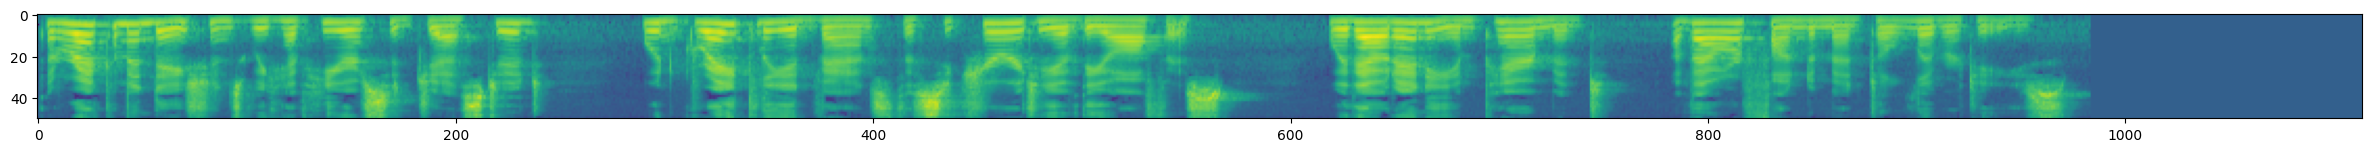

In [205]:
# Display padding test
fig = plt.figure(figsize=(30, 10))
plt.imshow(mel_specgram_padded);